# Deconvolution Using In-House V2 Panel (CD4 CD8 separate)

Here we will construct reference matrix to estimate standard cell-type proportions using in-house v2 panel. Our focus is on CRC/AA samples. Thus we will only include broad immune cell-types, abundant non-immune cell-types and colon/small-intestine epithelial cells.

## Initialisation

In [1]:
import os
import numpy as np
import pandas as pd
import random
import glob
import datetime
import itertools
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

### Parameters and File Paths

In [2]:
FILTER_COV = 10
SCORE_VAR = 'frac_alpha_leq_25pct'
#--- Local paths
ROOT_DIR = '/analysis/gh-msun/projects'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG)
DATA_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG) + '/stage'

SAMPLE_PATH = DATA_DIR + '/metadata/samples_wgbs.20230329.tsv'

# Methylation scores for reference WGBS samples.
SCORE_PATH = (
    DATA_DIR + '/ref_methyl_summaries/meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.tsv.gz'
)
# SCORE_PATH = (
#     '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/meth_summaries/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz'
# )

# Region annotation
REGION_PATH = (
    DATA_DIR + '/panel_data/deconvolution_v2.v23_panel_design.tsv.gz'
)
# Where to store deconvolution results
RESULTS_PATH = (
    PROJECT_DIR + '/output/deconv_inhouse_v2'
)

In [41]:
SAMPLE_PATH

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/stage/metadata/samples_wgbs.20230329.tsv'

### Sample Metadata

In [3]:
SCORE_PATH

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/stage/ref_methyl_summaries/meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.tsv.gz'

In [4]:
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
ridxs = sample_df['source'].isin(['blueprint_loyfer2022'])
sample_df = sample_df[ridxs].copy()

In [5]:
sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,GSM5652176,Z000000T7,Adipocytes,Adipocytes,53.0,blueprint_loyfer2022,NaN,NaN
1,GSM5652177,Z000000T9,Adipocytes,Adipocytes,35.0,blueprint_loyfer2022,NaN,NaN
2,GSM5652178,Z000000T5,Adipocytes,Adipocytes,37.0,blueprint_loyfer2022,NaN,NaN
3,GSM5652179,Endothelium,Endothelium,Endothelium,33.0,blueprint_loyfer2022,NaN,NaN
4,GSM5652180,Endothelium,Endothelium,Endothelium,62.0,blueprint_loyfer2022,NaN,NaN


In [6]:
sample_df['cell_type'].unique()

array(['Adipocytes', 'Endothelium', 'Fibroblast', 'Striated muscle',
       'Smooth muscle', 'Cardiomyocyte', 'Osteoblasts',
       'Oligodendrocytes', 'Neuronal', 'Hepatocyte', 'Duct', 'Acinar',
       'Delta', 'Beta', 'Alpha', 'Epithelium', 'Podocyte',
       'Erythrocyte progenitors', 'T (CD3+) cells',
       'T helper(CD4+) cells', 'T cytotoxic (CD8+) cells',
       'T central memory CD4', 'T effector cell CD8',
       'T effector memory CD4', 'T effector memory CD8',
       'Naive T cells CD4', 'Naive T cells CD8', 'NK', 'Monocytes',
       'Macrophages', 'Granulocytes', 'B cells', 'Memory B cells',
       'keratinocyte', 'Luminal epithelial', 'Basal epithelial',
       'Endocrine', 'endothelial cell of umbilical vein (proliferating)',
       'endothelial cell of umbilical vein (resting)',
       'band form neutrophil', 'neutrophilic metamyelocyte',
       'neutrophilic myelocyte', 'segmented neutrophil of bone marrow',
       'precursor B cell', 'precursor lymphocyte of B lineage

In [7]:
sample_df['sample_group'].unique()

array(['Adipocytes', 'Endothelium', 'Colon-Fibro', 'Heart-Fibro',
       'Dermal-Fibro', 'Skeletal-Musc', 'Smooth-Musc', 'Heart-Cardio',
       'Bone-Osteob', 'Oligodend', 'Neuron', 'Liver-Hep', 'Pancreas-Duct',
       'Pancreas-Acinar', 'Pancreas-Delta', 'Pancreas-Beta',
       'Pancreas-Alpha', 'Kidney-Ep', 'Thyroid-Ep', 'Fallopian-Ep',
       'Ovary+Endom-Ep', 'Eryth-prog', 'Blood-T', 'Blood-NK',
       'Blood-Mono+Macro', 'Blood-Granul', 'Blood-B', 'Epid-Kerat',
       'Head-Neck-Ep', 'Lung-Ep-Bron', 'Prostate-Ep', 'Bladder-Ep',
       'Breast-Luminal-Ep', 'Breast-Basal-Ep', 'Lung-Ep-Alveo',
       'Gallbladder', 'Gastric-Ep', 'Colon-Ep', 'Small-Int-Ep',
       'Umbilical-Endothelium', 'Blueprint-Neutro', 'Blueprint-B',
       'Blueprint-Mono', 'Blueprint-CD8', 'Blueprint-NK',
       'Blueprint-Macro', 'Blueprint-Eryth', 'Blueprint-Mega',
       'Blueprint-Dend', 'Blueprint-CD4', 'Blueprint-Eosi'], dtype=object)

In [8]:
# summary = sample_df\
#     .fillna('none')\
#     .groupby(['sample_group'])\
#     .size()
# summary

### Regions

In [9]:
region_df = pd.read_csv(REGION_PATH, sep='\t')
ridxs = (region_df['v23_conv']==1)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1930, 1658)

Duplication is due to the fact that some regions are spread across several MSRE cut-site clusters.

In [10]:
region_df = region_df[['region_id', 'subpanel', 'target_celltype']].drop_duplicates()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [11]:
region_df.head()

,region_id,subpanel,target_celltype
0,Immune_Broad_B-chr1:1114772-1114971,immune_broad,Immune_Broad_B
1,Immune_Broad_NK-chr1:1157451-1157720,immune_broad,Immune_Broad_NK
2,Immune_Broad_NK-chr1:1157880-1158277,immune_broad,Immune_Broad_NK
3,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...,external,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...
5,Pancreas_Acinar-chr1:1849568-1849674,nonimmune,Pancreas_Acinar


In [12]:
region_df.target_celltype.unique()

array(['Immune_Broad_B', 'Immune_Broad_NK',
       'Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-Int-Ep',
       'Pancreas_Acinar', 'Immune_Lymph_CD8_Naive_wo_CM',
       'Breast_Basal_Ep', 'Immune_Refined_CD4_Reg', 'Breast_Luminal_Ep',
       'Loyfer2022_Published_Colon-Ep:Small-Int-Ep',
       'Loyfer2022_Preprint_Blood-Granul', 'Literature_Age', 'Kidney_Ep',
       'Immune_Broad_Eosi', 'Immune_Refined_B_Memory_Switched',
       'Immune_Broad_Neutro', 'Pancreas', 'Immune_Refined_B_Memory',
       'Liver_Hep', 'Immune_Broad_Dend', 'Adipocytes',
       'Immune_Refined_Macro', 'Immune_Refined_Eryth', 'Pancreas_Duct',
       'Eryth_prog', 'Gastric_Ep', 'Loyfer2022_Preprint_Breast-Basal-Ep',
       'Loyfer2022_Preprint_Blood-T', 'Heart_Cardio', 'Esophagus_Ep',
       'Head_Neck_Ep', 'Lung_Ep_Bron', 'Small_Int_Ep', 'Ovary_Ep',
       'Loyfer2022_Preprint_Blood-Mono+Macro',
       'Loyfer2022_Preprint_Colon-Ep',
       'Loyfer2022_Preprint_Lung-Ep-Alveo',
       'Loyfer2022_Preprint_Colon-

In [13]:
summary = region_df.groupby(['subpanel', 'target_celltype']).size()
summary

subpanel            target_celltype                                      
external            Literature_Age                                            30
                    Literature_Immune                                         30
                    Loyfer2022_Preprint_Blood-B                               13
                    Loyfer2022_Preprint_Blood-Granul                          13
                    Loyfer2022_Preprint_Blood-Mono+Macro                      15
                    Loyfer2022_Preprint_Blood-NK                              13
                    Loyfer2022_Preprint_Blood-T                               16
                    Loyfer2022_Preprint_Breast-Basal-Ep                       25
                    Loyfer2022_Preprint_Breast-Basal-Ep:Breast-Luminal-Ep     22
                    Loyfer2022_Preprint_Colon-Ep                              13
                    Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-Int-Ep      14
                    Loyfer2022_Prep

In [14]:
# ridxs = region_df['subpanel'].isin(['external','immune_broad','immune_refined','immune_specialised'])
# region_df = region_df[ridxs]
# region_df.shape[0], region_df['region_id'].nunique()

### Methylation Scores

In [15]:
score_df = pd.read_csv(SCORE_PATH, sep='\t')

# index score df
ridxs = score_df['sample_id'].isin(sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(region_df['region_id'])

score_df = score_df[ridxs].copy()
score_df.shape[0], score_df['region_id'].nunique()

(509090, 1648)

## Construct Reference Matrix

What samples/regions define reference atlas?

In [17]:
# 'Immune_Broad_Mono'
# 'Immune_Broad_Macro'
# 'Immune_Broad_Dend'

# 'Blood-Granul'
# Loyfer2022_Preprint_Blood-Granul 

SAMPLE_TO_REF_CELLTYPE_MAP = {   # blue print
    # 'Blueprint-B': 'immune_b',
    # 'Blueprint-CD4': 'immune_cd4',
    # 'Blueprint-CD8': 'immune_cd8',
    # 'Blueprint-NK': 'immune_nk',
    # 'Blueprint-Dend': 'immune_dend_plus_macro_plus_mono',
    # 'Blueprint-Macro': 'immune_dend_plus_macro_plus_mono',
    # 'Blueprint-Mono': 'immune_dend_plus_macro_plus_mono',
        # 'Blueprint-Neutro': 'immune_neutro',
    'Blueprint-Eosi': 'immune_eosi',
    'Blueprint-Eryth': 'immune_eryth',
    'Blueprint-Mega': 'immune_mega',
    'Eryth-prog': 'eryth_prog',
    'Blood-B': 'immune_b', 
    'Blood-T': 'immune_t', 
    'Blood-Mono+Macro':'immune_dend_plus_macro_plus_mono' , 
    'Blood-NK': 'immune_nk', 
    'Blood-Granul': 'immune_neutro'
}

REGION_TO_REF_CELLTYPE_MAP= {  # hypo panel
    'Immune_Broad_B': 'immune_b',
    'Immune_Broad_CD4_plus_CD8': 'immune_t',
    'Immune_Broad_NK': 'immune_nk',
    'Immune_Broad_Dend_plus_Macro_plus_Mono': 'immune_dend_plus_macro_plus_mono',
    'Immune_Broad_Eosi': 'immune_eosi',
    'Immune_Broad_Neutro': 'immune_neutro',
    'Immune_Refined_Eryth': 'immune_eryth',
    'Immune_Refined_Mega': 'immune_mega',
    'Eryth_prog': 'eryth_prog'
} 

In [18]:
ridxs = (sample_df['source']=='blueprint_loyfer2022')
ridxs &= sample_df['sample_group'].isin(SAMPLE_TO_REF_CELLTYPE_MAP.keys())
ref_sample_df = sample_df[ridxs].copy()
ref_sample_df['ref_celltype'] = ref_sample_df['sample_group'].map(SAMPLE_TO_REF_CELLTYPE_MAP)
ref_sample_df.shape[0], ref_sample_df['sample_id'].nunique(), ref_sample_df['ref_celltype'].nunique()

(53, 53, 9)

In [19]:
region_df['target_celltype'].head()

0                                       Immune_Broad_B
1                                      Immune_Broad_NK
2                                      Immune_Broad_NK
3    Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...
5                                      Pancreas_Acinar
Name: target_celltype, dtype: object

In [20]:
ridxs = region_df['target_celltype'].isin(REGION_TO_REF_CELLTYPE_MAP.keys())
ref_region_df = region_df[ridxs][['region_id', 'target_celltype']].drop_duplicates()
ref_region_df['ref_celltype'] = ref_region_df['target_celltype'].map(REGION_TO_REF_CELLTYPE_MAP)
ref_region_df.shape[0], ref_region_df['region_id'].nunique(), ref_region_df['ref_celltype'].nunique()

(301, 301, 9)

In [21]:
# number of regions per cell type
ref_region_df.groupby(['ref_celltype'])['region_id'].nunique()

ref_celltype
eryth_prog                          22
immune_b                            49
immune_dend_plus_macro_plus_mono    13
immune_eosi                         38
immune_eryth                        25
immune_mega                         29
immune_neutro                       29
immune_nk                           53
immune_t                            43
Name: region_id, dtype: int64

In [22]:
ridxs = (score_df['number_molecules']>=FILTER_COV)
ridxs &= score_df['sample_id'].isin(ref_sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(ref_region_df['region_id'])
atlas = score_df[ridxs][['sample_id', 'region_id', SCORE_VAR]]\
    .merge(ref_sample_df[['sample_id', 'ref_celltype']])\
    .groupby(['region_id', 'ref_celltype'])\
    [SCORE_VAR].mean()\
    .reset_index()\
    .pivot_table(index='region_id', columns='ref_celltype', values=SCORE_VAR)
atlas.shape

(301, 9)

In [23]:
ridxs = (atlas.isna().sum(axis=1)==0)
atlas = atlas[ridxs].copy()
atlas.shape

(275, 9)

In [24]:
ref_sample_df['ref_celltype'].unique()

array(['eryth_prog', 'immune_t', 'immune_nk',
       'immune_dend_plus_macro_plus_mono', 'immune_neutro', 'immune_b',
       'immune_eryth', 'immune_mega', 'immune_eosi'], dtype=object)

Rearrange columns and rows of atlas matrix to conform to desired order.

In [25]:
ref_region_df = pd.DataFrame({'ref_celltype': list(REGION_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_region_df)
ridxs = ref_region_df['region_id'].isin(atlas.index)
ref_region_df = ref_region_df[ridxs].copy()
ref_sample_df = pd.DataFrame({'ref_celltype': list(SAMPLE_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_sample_df)
atlas = atlas.loc[ref_region_df['region_id'], ref_sample_df['ref_celltype'].unique()]
atlas.shape

(275, 9)

In [26]:
ref_sample_df.head()

,ref_celltype,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,immune_eosi,ERS523618,S006XE,mature eosinophil,Blueprint-Eosi,65 - 70,blueprint_loyfer2022,NaN,NaN
1,immune_eosi,ERS763494,S00V65,mature eosinophil,Blueprint-Eosi,65 - 70,blueprint_loyfer2022,NaN,NaN
2,immune_eryth,ERS433774,S002R5,erythroblast,Blueprint-Eryth,0 - 5,blueprint_loyfer2022,NaN,NaN
3,immune_eryth,ERS358627,S002S3,erythroblast,Blueprint-Eryth,0 - 5,blueprint_loyfer2022,NaN,NaN
4,immune_mega,ERS642830,S004AV,"CD34-negative, CD41-positive, CD42-positive me...",Blueprint-Mega,0 - 5,blueprint_loyfer2022,NaN,NaN


## Reference Matrix Heatmap

In [27]:
## Make the heatmap with R - not necessary if R is not installed
# %%R -i atlas,ref_region_df,RESULTS_PATH
# library(tidyverse)
# library(pheatmap)
# library(pals)

# save_pheatmap_pdf <- function(x, filename, width=12, height=14) {
#    stopifnot(!missing(x))
#    stopifnot(!missing(filename))
#    pdf(filename, width=width, height=height)
#    grid::grid.newpage()
#    grid::grid.draw(x$gtable)
#    dev.off()
# }

# # Cell-type annotation
# col_annot = data.frame(celltype=colnames(atlas))
# rownames(col_annot) = colnames(atlas)
# celltype_colors = c(stepped(), stepped2())[1:length(colnames(atlas))]
# names(celltype_colors) = colnames(atlas)
# # Region annotation
# row_annot = data.frame(region_celltype=ref_region_df$ref_celltype)
# rownames(row_annot) = ref_region_df$region_id
# region_celltype_colors = c(stepped(), stepped2())[1:length(unique(ref_region_df$ref_celltype))]
# names(region_celltype_colors) = unique(ref_region_df$ref_celltype)
# annot_colors = list(celltype=celltype_colors, region_celltype=region_celltype_colors)
# # Heatmap
# p = pheatmap(
#     atlas, 
#     cluster_rows=FALSE, show_rownames=FALSE, 
#     cluster_cols=FALSE, show_colnames=FALSE, 
#     annotation_colors=annot_colors,
#     annotation_row=row_annot, annotation_names_row=FALSE,
#     annotation_col=col_annot, annotation_names_col=FALSE,
#     scale='none', clustering_method='ward.D2',
# )
# ofile <- sprintf('%s_heatmap_atlas.pdf', RESULTS_PATH)
# save_pheatmap_pdf(p, file=ofile)

In [28]:
atlas.shape

(275, 9)

In [29]:
atlas.head()

ref_celltype,immune_eosi,immune_eryth,immune_mega,eryth_prog,immune_b,immune_t,immune_dend_plus_macro_plus_mono,immune_nk,immune_neutro
region_id,,,,,,,,,
Immune_Broad_B-chr1:1114772-1114971,0.005208,0.013889,0.012048,0.030417,0.956841,0.001166,0.019070,0.000000,0.0
Immune_Broad_B-chr10:45390756-45390847,0.000000,0.064953,0.021491,0.206392,0.919831,0.001701,0.019512,0.025974,0.0
Immune_Broad_B-chr10:126289835-126290065,0.000000,0.000000,0.005155,0.055057,0.957045,0.000745,0.017136,0.071835,0.0
Immune_Broad_B-chr10:126290368-126290506,0.048423,0.009259,0.000000,0.031746,0.936381,0.031110,0.020140,0.066467,0.0
Immune_Broad_B-chr11:75988912-75989088,0.000000,0.008475,0.007576,0.113996,0.987238,0.007891,0.018468,0.000000,0.0


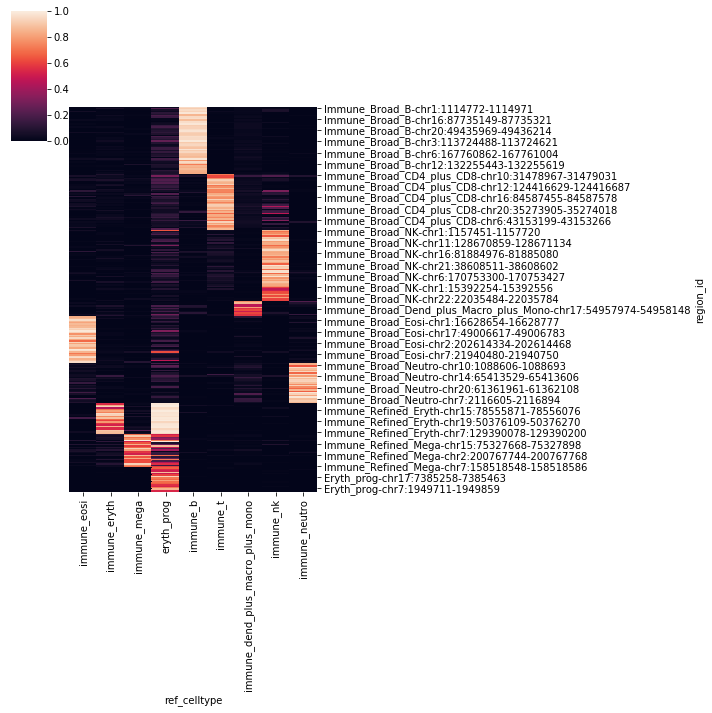

In [30]:
sns.clustermap(atlas, row_cluster=False, col_cluster=False)

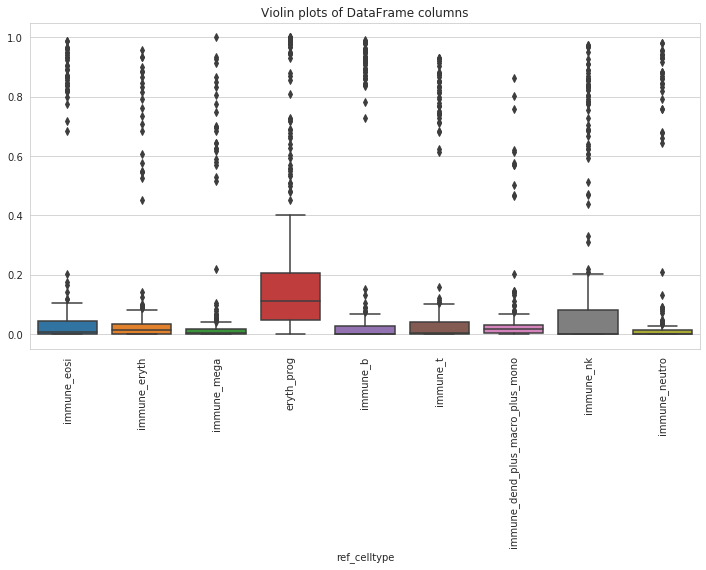

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Assuming df is your DataFrame
# df = pd.DataFrame({...})

plt.figure(figsize=(12, 6))  # Adjust as necessary

# The following line does the actual plotting
# It loops over each column in your DataFrame and adds a violin plot for it
sns.boxplot(data=atlas)

plt.xticks(rotation=90)  # Rotates X-axis labels if they overlap
plt.title("Violin plots of DataFrame columns")  # You can customize title here
plt.show()

# plot mean, median, variance more clearly, plot mean vs variance 

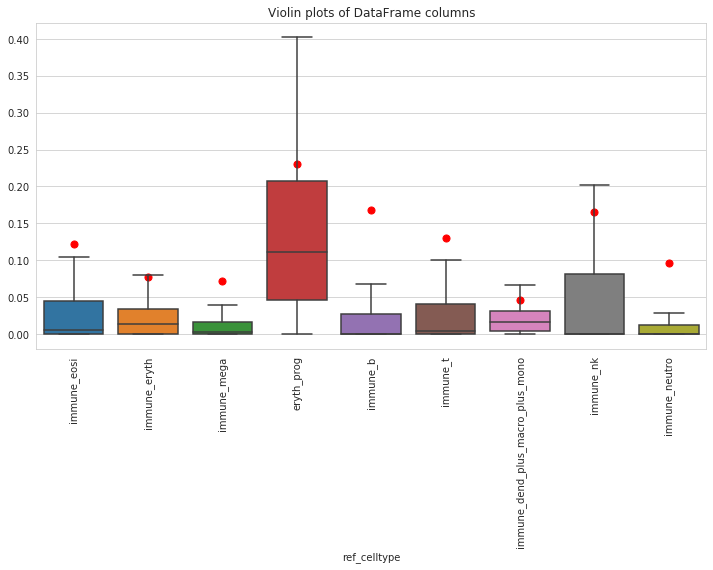

In [32]:
sns.set_style("whitegrid")

# Assuming df is your DataFrame
# df = pd.DataFrame({...})

plt.figure(figsize=(12, 6))  # Adjust as necessary

# The following line does the actual plotting
# It loops over each column in your DataFrame and adds a violin plot for it
sns.boxplot(data=atlas, showfliers=False)

for i, column in enumerate(atlas.columns):
    plt.scatter(i, atlas[column].mean(), color='red', s=50) 

plt.xticks(rotation=90)  # Rotates X-axis labels if they overlap
plt.title("Violin plots of DataFrame columns")  # You can customize title here
# plt.ylim(0, 0.1)
plt.show()


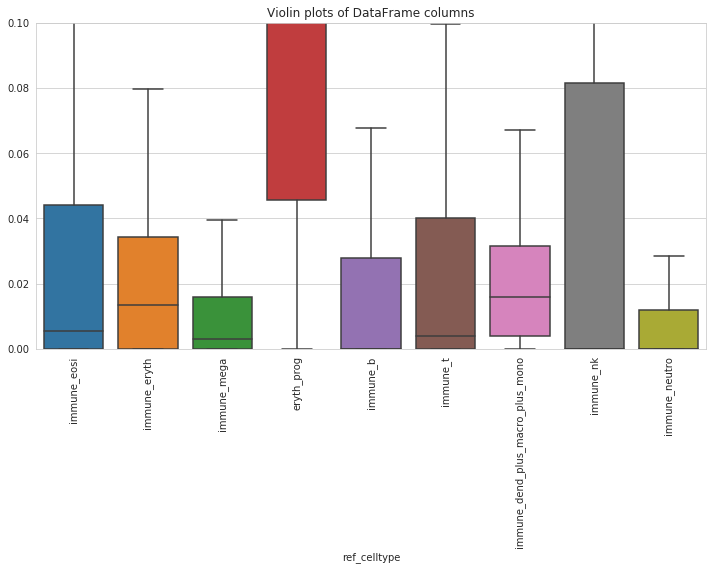

In [33]:

sns.set_style("whitegrid")

# Assuming df is your DataFrame
# df = pd.DataFrame({...})

plt.figure(figsize=(12, 6))  # Adjust as necessary

# The following line does the actual plotting
# It loops over each column in your DataFrame and adds a violin plot for it
sns.boxplot(data=atlas, showfliers=False)
plt.ylim(0, 0.1)
plt.xticks(rotation=90)  # Rotates X-axis labels if they overlap
plt.title("Violin plots of DataFrame columns")  # You can customize title here
plt.show()

# plot mean, median, variance more clearly, plot mean vs variance 

In [ ]:
    'immune_eosi',
    'immune_eryth',
    'immune_mega',
    'eryth_prog',
    'immune_b', 
    'immune_t', 
    'immune_dend_plus_macro_plus_mono' , 
    'immune_nk', 
    'immune_neutro'

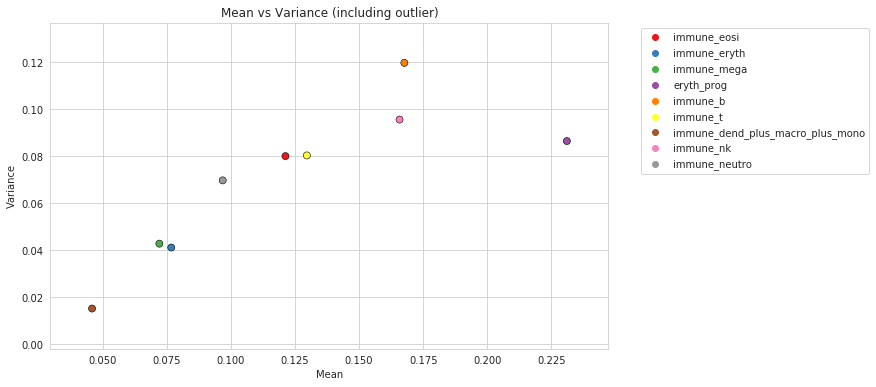

In [35]:
# Calculate the means and variances
means = atlas.mean()
variances = atlas.var()

# Create a new DataFrame with means and variances
df_mean_variance = pd.DataFrame({'mean': means, 'variance': variances, 'celltype':[    
                                                                                    'immune_eosi',
                                                                                    'immune_eryth',
                                                                                    'immune_mega',
                                                                                    'eryth_prog',
                                                                                    'immune_b', 
                                                                                    'immune_t', 
                                                                                    'immune_dend_plus_macro_plus_mono' , 
                                                                                    'immune_nk', 
                                                                                    'immune_neutro']})

# Reset index to get columns as a field
df_mean_variance.reset_index(inplace=True)

# Use seaborn to create a scatterplot with different colors for each column
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='variance', hue='celltype', data=df_mean_variance, palette='Set1', s=50,  edgecolor='black')

plt.title('Mean vs Variance (including outlier)')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

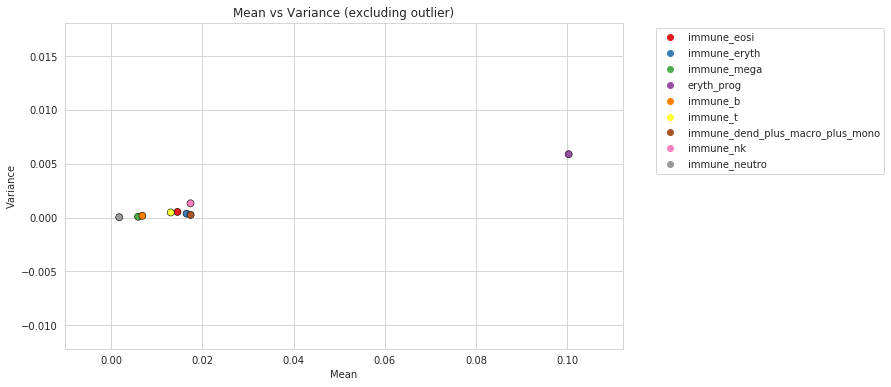

In [36]:
# Initialize a DataFrame to hold your results
atlas_no_outliers = pd.DataFrame()

# Iterate over each column in your DataFrame
for col in atlas.columns:
    Q1 = atlas[col].quantile(0.25)
    Q3 = atlas[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the criteria for a "non-outlier" in this column
    non_outliers = (atlas[col] >= Q1 - 1.5*IQR) & (atlas[col] <= Q3 + 1.5*IQR)

    # Add the non-outliers of this column to your new DataFrame
    atlas_no_outliers[col] = atlas[col][non_outliers]

# Now you can calculate the mean and variance of each column, excluding outliers
means = atlas_no_outliers.mean()
variances = atlas_no_outliers.var()

# Create a new DataFrame with means and variances
df_mean_variance = pd.DataFrame({'mean': means, 'variance': variances, 'celltype':[    'immune_eosi',
    'immune_eryth',
    'immune_mega',
    'eryth_prog',
    'immune_b', 
    'immune_t', 
    'immune_dend_plus_macro_plus_mono' , 
    'immune_nk', 
    'immune_neutro']})

# Reset index to get columns as a field
df_mean_variance.reset_index(inplace=True)

# Use seaborn to create a scatterplot with different colors for each column
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='variance', hue='celltype', data=df_mean_variance, palette='Set1', s=50,  edgecolor='black')

plt.title('Mean vs Variance (excluding outlier)')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## SVD Decomposition of Atlas

In [37]:
u, s, v = np.linalg.svd(atlas, compute_uv=True, full_matrices=False)
s

array([7.32282793, 6.25483583, 5.86325921, 5.09931989, 4.87939984,
       4.59057827, 3.46297679, 2.0879043 , 1.84705554])

## Write Out

Reference atlas.

In [38]:
ofile = RESULTS_PATH + '.loyfer.atlas.tsv.gz'
rv = atlas.reset_index()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Region to reference cell type mapping.

In [39]:
ofile = RESULTS_PATH + '.loyfer.region_to_ref_celltype.tsv.gz'
rv = ref_region_df[['region_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Sample to reference cell type mapping.

In [40]:
ofile = RESULTS_PATH + '.loyfer.sample_to_ref_celltype.tsv.gz'
rv = ref_sample_df[['sample_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)